# Running the U-Net model to Segment Roads from Satellite Images

In [1]:
!pip install torch

In [2]:
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 1.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [3]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=a0a178d261e4845d4cf391e2ea4c1d7b4559f57dd9ec5d69d5aadd50b8d9d644
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=21427fd6d1cc0ad27b2776ca4d27d6036a61f0303b8a8c30c8a65ab1b7aec558
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


Importing the libraries

In [4]:
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [5]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 30.62 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [6]:
import sys
sys.path.append('/content/Road_seg_dataset')

Setting up configuration

In [7]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

images                  masks
0  images/17428750_15.png  masks/17428750_15.png
1  images/23279080_15.png  masks/23279080_15.png
2  images/24179185_15.png  masks/24179185_15.png
3  images/24179035_15.png  masks/24179035_15.png
4  images/11128810_15.png  masks/11128810_15.png

In [9]:
idx = 2

row_id = df.iloc[idx]

image_path = DATA_DIR + row_id.images
mask_path = DATA_DIR + row_id.masks

In [10]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

Plotting the image and the mask

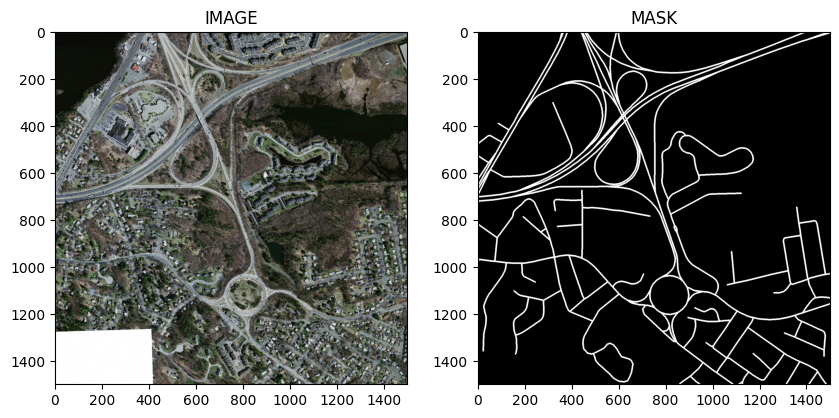

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

Splitting dataset into train and tests

In [12]:
df_train, df_test = train_test_split(df, test_size = .20, random_state = 42)

In [13]:
print(len(df_train), len(df_test))

159 40


# **Importing the Augmentation function**

For that we are going to use the albumentation function created by the https://albumentations.ai

In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-jpoyrpdk
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-jpoyrpdk
  Resolved https://github.com/albumentations-team/albumentations to commit a22a319b2e7079389326e5b7830e71017701b1b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 974.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 1.2 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.4-py3-none-any.whl size=152687 sha256=8803a01ca5055c35bcb7424a06830ed4af9d1b4e6139a60c2363f01a1b94f176
  Stored in directory: /tmp/pip-ephem-wheel-cache-notj8bo6/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3

In [14]:
import albumentations as A

In [15]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_test_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# **Creating custom datasets using PyTorch**

In [16]:
from torch.utils.data import Dataset

In [17]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row_id = self.df.iloc[idx]

    image_path = DATA_DIR + row_id.images
    mask_path = DATA_DIR + row_id.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #add the channel dimension to mask to add the channel dimension
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #change the image and mask format from h x w x c to c x h x w

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [18]:
trainset = SegmentationDataset(df_train , get_train_augs())
testset = SegmentationDataset(df_test , get_test_augs())

In [19]:
len(trainset)

159

In [20]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

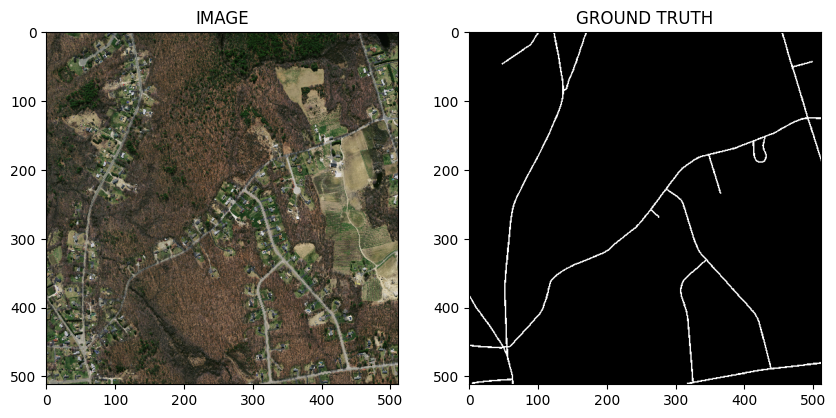

In [21]:
idx = 69

image, mask = trainset[idx]

show_image(image,mask)

# **Loading the Datasets into batches**

In [22]:
from torch.utils.data import DataLoader

In [23]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(trainset, batch_size = BATCH_SIZE)

In [24]:
len(trainloader)

20

# **Creating the Segmentation Model**

In [25]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [26]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes =1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [27]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 153MB/s]


# **Create the training and testing function**

In [28]:
def train_fn(dataloader, model, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        predicted = (logits > 0.5).float()  # Convert logits to binary predictions
        correct += (predicted == masks).sum().item()
        total += masks.numel()

    accuracy = 100. * correct / total
    return total_loss / len(dataloader), accuracy






In [29]:

def test_fn(dataloader, model):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

            # Calculate accuracy
            predicted = (logits > 0.5).float()  # Convert logits to binary predictions
            correct += (predicted == masks).sum().item()
            total += masks.numel()

    accuracy = 100. * correct / total
    return total_loss / len(dataloader), accuracy


# **Model Training**

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
import numpy as np

best_loss = np.Inf
best_accuracy = 0.0

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_fn(trainloader, model, optimizer)
    test_loss, test_accuracy = test_fn(testloader, model)

    if test_loss < best_loss:
        torch.save(model.state_dict(), "road_final.pt")
        print(f'Model Saved')
        best_loss = test_loss
        best_accuracy = test_accuracy

    print(f"Epoch: {epoch+1}, Train loss: {train_loss}, Train accuracy: {train_accuracy}, Test loss: {test_loss}, Test accuracy: {test_accuracy}")

print(f"Best Test Loss: {best_loss}, Best Test Accuracy: {best_accuracy}")

100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Model Saved
Epoch: 1, Train loss: 1.521607357263565, Train accuracy: 84.07019369257321, Test loss: 1.204814040660858, Test accuracy: 94.95906709874951


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Model Saved
Epoch: 2, Train loss: 0.9856021374464035, Train accuracy: 94.81337205419001, Test loss: 0.8976481527090072, Test accuracy: 94.79507110403769


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Model Saved
Epoch: 3, Train loss: 0.7903882741928101, Train accuracy: 94.6292205426678, Test loss: 0.8731358200311661, Test accuracy: 91.81002490925339


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Model Saved
Epoch: 4, Train loss: 0.7249192029237748, Train accuracy: 95.05951359586895, Test loss: 0.6864472538232803, Test accuracy: 95.47100906851907


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Model Saved
Epoch: 5, Train loss: 0.6849435538053512, Train accuracy: 95.37836230775845, Test loss: 0.673816642165184, Test accuracy: 95.17270933906987


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Model Saved
Epoch: 6, Train loss: 0.6600987434387207, Train accuracy: 95.50859703207915, Test loss: 0.665378350019455, Test accuracy: 95.0981044169492


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Model Saved
Epoch: 7, Train loss: 0.654031389951706, Train accuracy: 95.58013580130331, Test loss: 0.6548420667648316, Test accuracy: 95.35783731712485


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Model Saved
Epoch: 8, Train loss: 0.6574266344308853, Train accuracy: 95.55041715034149, Test loss: 0.6253993332386016, Test accuracy: 95.95358026852398


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Model Saved
Epoch: 9, Train loss: 0.6223422318696976, Train accuracy: 95.78180133171801, Test loss: 0.6179867208003997, Test accuracy: 95.97910035331294


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Epoch: 10, Train loss: 0.6282011419534683, Train accuracy: 95.8099845070509, Test loss: 0.621851772069931, Test accuracy: 95.46393868308397


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch: 11, Train loss: 0.6334528803825379, Train accuracy: 95.71269533169344, Test loss: 0.6275228530168533, Test accuracy: 95.81923334853454


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch: 12, Train loss: 0.6269128322601318, Train accuracy: 95.76810201009114, Test loss: 0.6434442967176437, Test accuracy: 95.28211197763119


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Model Saved
Epoch: 13, Train loss: 0.6166224002838134, Train accuracy: 95.79396757689662, Test loss: 0.6027252614498139, Test accuracy: 95.9207258884262


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Model Saved
Epoch: 14, Train loss: 0.608710664510727, Train accuracy: 95.85455648554196, Test loss: 0.5920190826058388, Test accuracy: 96.0880087606562


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch: 15, Train loss: 0.6090568900108337, Train accuracy: 95.94253204153769, Test loss: 0.594950670003891, Test accuracy: 95.98608436824391


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Model Saved
Epoch: 16, Train loss: 0.6043255984783172, Train accuracy: 95.91269583072302, Test loss: 0.5865838974714279, Test accuracy: 96.04039462107532


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Model Saved
Epoch: 17, Train loss: 0.5848109632730484, Train accuracy: 96.02483593442905, Test loss: 0.5745694294571877, Test accuracy: 96.13155149063974


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch: 18, Train loss: 0.5841017320752144, Train accuracy: 96.06498142458358, Test loss: 0.5892395704984665, Test accuracy: 95.94335496050756


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch: 19, Train loss: 0.5878618314862252, Train accuracy: 95.99199115105395, Test loss: 0.5895196765661239, Test accuracy: 96.2735781879545


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Model Saved
Epoch: 20, Train loss: 0.5768747687339782, Train accuracy: 96.10454391383524, Test loss: 0.5679021000862121, Test accuracy: 96.22159034201184


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Model Saved
Epoch: 21, Train loss: 0.5805925592780113, Train accuracy: 96.05093182257886, Test loss: 0.557459081709385, Test accuracy: 96.25327392194257


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch: 22, Train loss: 0.5715786099433899, Train accuracy: 96.14627766159346, Test loss: 0.5604258880019188, Test accuracy: 96.14669511903007


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


Epoch: 23, Train loss: 0.573722305893898, Train accuracy: 96.14466301300241, Test loss: 0.5620863810181618, Test accuracy: 96.15440128734276


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch: 24, Train loss: 0.5783292546868324, Train accuracy: 96.17359953106575, Test loss: 0.7090276151895523, Test accuracy: 95.35563726845028


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

Epoch: 25, Train loss: 0.5828571692109108, Train accuracy: 96.06399536132812, Test loss: 0.5810279846191406, Test accuracy: 95.85784576224081
Best Test Loss: 0.557459081709385, Best Test Accuracy: 96.25327392194257


In [32]:
idx = 20

model.load_state_dict(torch.load('/content/road_final.pt'))

image, mask = testset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0


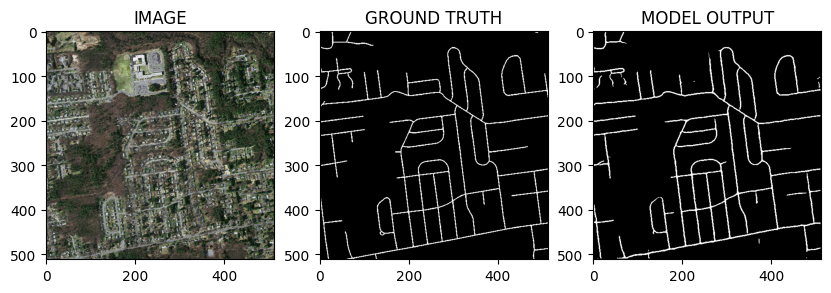

In [33]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [34]:

import torchvision.transforms.functional as TF
pred_mask = pred_mask.squeeze(0)
image_pil = TF.to_pil_image(image)
mask_pil = TF.to_pil_image(mask)
pred_mask_pil = TF.to_pil_image(pred_mask)


image_pil.save('/content/image.png')
mask_pil.save('/content/ground_truth_mask.png')
pred_mask_pil.save('/content/predicted_mask.png')

In [35]:
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [36]:
print(model)


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Overlapping the maps produced from the U-Net model with the original images


Original image shape: (512, 512, 3)
Map image shape: (512, 512)


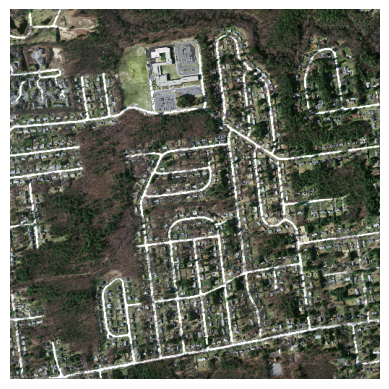

Image saved successfully


In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

org_image = cv2.imread('/content/image.png')
if org_image is None:
    print("Error: Failed to load original image")
else:
    print("Original image shape:", org_image.shape)

map_image = cv2.imread('/content/predicted_mask.png', cv2.IMREAD_UNCHANGED)
if map_image is None:
    print("Error: Failed to load map image")
else:
    print("Map image shape:", map_image.shape)

if org_image is not None and map_image is not None:
    map_image_resized = cv2.resize(map_image, (org_image.shape[1], org_image.shape[0]))

    if len(map_image_resized.shape) > 2:
        map_image_resized = cv2.cvtColor(map_image_resized, cv2.COLOR_BGR2GRAY)

    _, binary_mask = cv2.threshold(map_image_resized, 1, 255, cv2.THRESH_BINARY)

    inverse_mask = cv2.bitwise_not(binary_mask)

    masked_lines = cv2.bitwise_and(org_image, org_image, mask=binary_mask)

    result = cv2.addWeighted(org_image, 1, masked_lines, 1, 0)

    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.imshow(result_rgb)
    plt.axis('off')
    plt.show()
    success = cv2.imwrite('road_extracted.png', result_rgb)
    if success:
      print("Image saved successfully")
    else:
      print("Error: Failed to save image")



# YOLOv8 model to detect the landing sites


In [2]:
!pip install yolov8


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 

In [38]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [39]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.4/78.2 GB disk)


In [40]:
from ultralytics import YOLO

from IPython.display import display, Image

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
%cd /content/drive/MyDrive/HelicopterLanding.v3i.yolov8

/content/drive/MyDrive/Helicopter Landing.v3i.yolov8


In [51]:
ls /content/drive/MyDrive/HelicopterLanding.v3i.yolov8

data.yaml           README.roboflow.txt  road_extracted.png  test/   valid/      yolov8s.pt
README.dataset.txt  result.png           runs/               train/  yolov8n.pt


In [ ]:

!yolo task=detect mode=train model=yolov8s.pt data= data.yaml epochs=25 imgsz=224 plots=True

In [57]:
!ls runs/detect/train3/

args.yaml					    R_curve.png		train_batch256.jpg
confusion_matrix.png				    results.csv		train_batch257.jpg
events.out.tfevents.1713891137.869c24d37f42.2585.0  results.png		train_batch2.jpg
F1_curve.png					    train_batch0.jpg	val_batch0_labels.jpg
P_curve.png					    train_batch1.jpg	val_batch0_pred.jpg
PR_curve.png					    train_batch255.jpg	weights


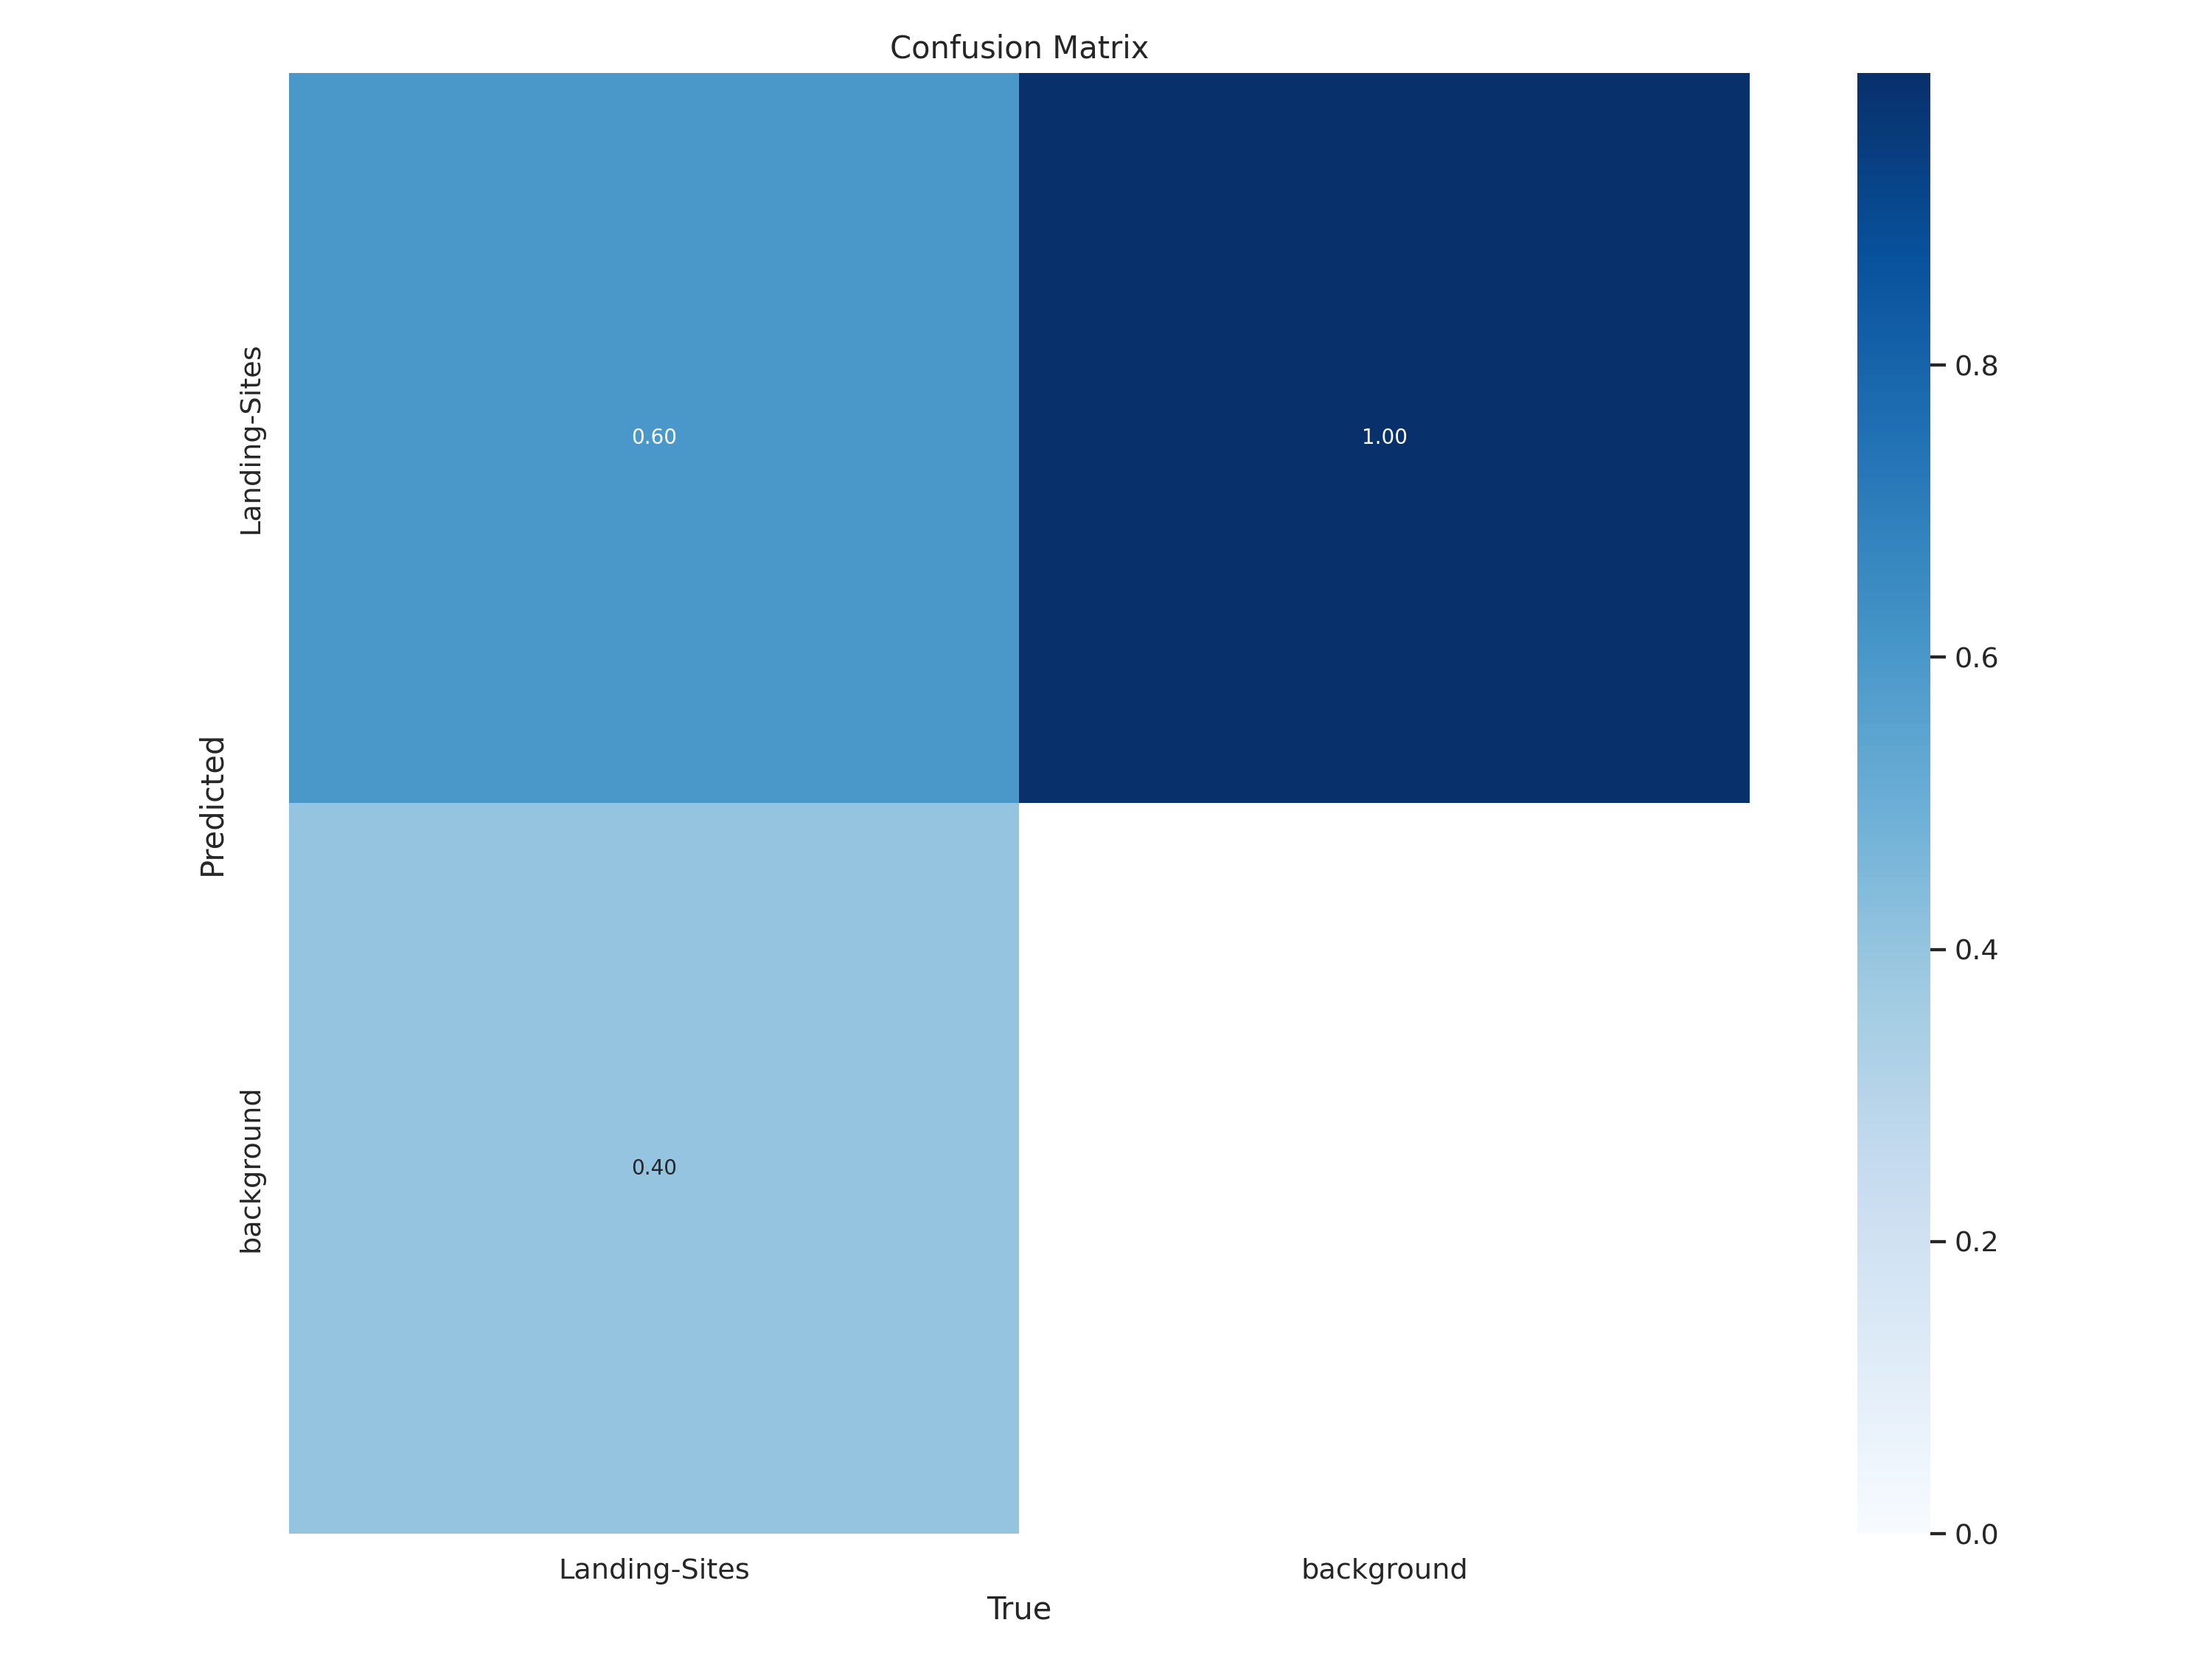

In [58]:
Image(filename='runs/detect/train3/confusion_matrix.png', width=600)

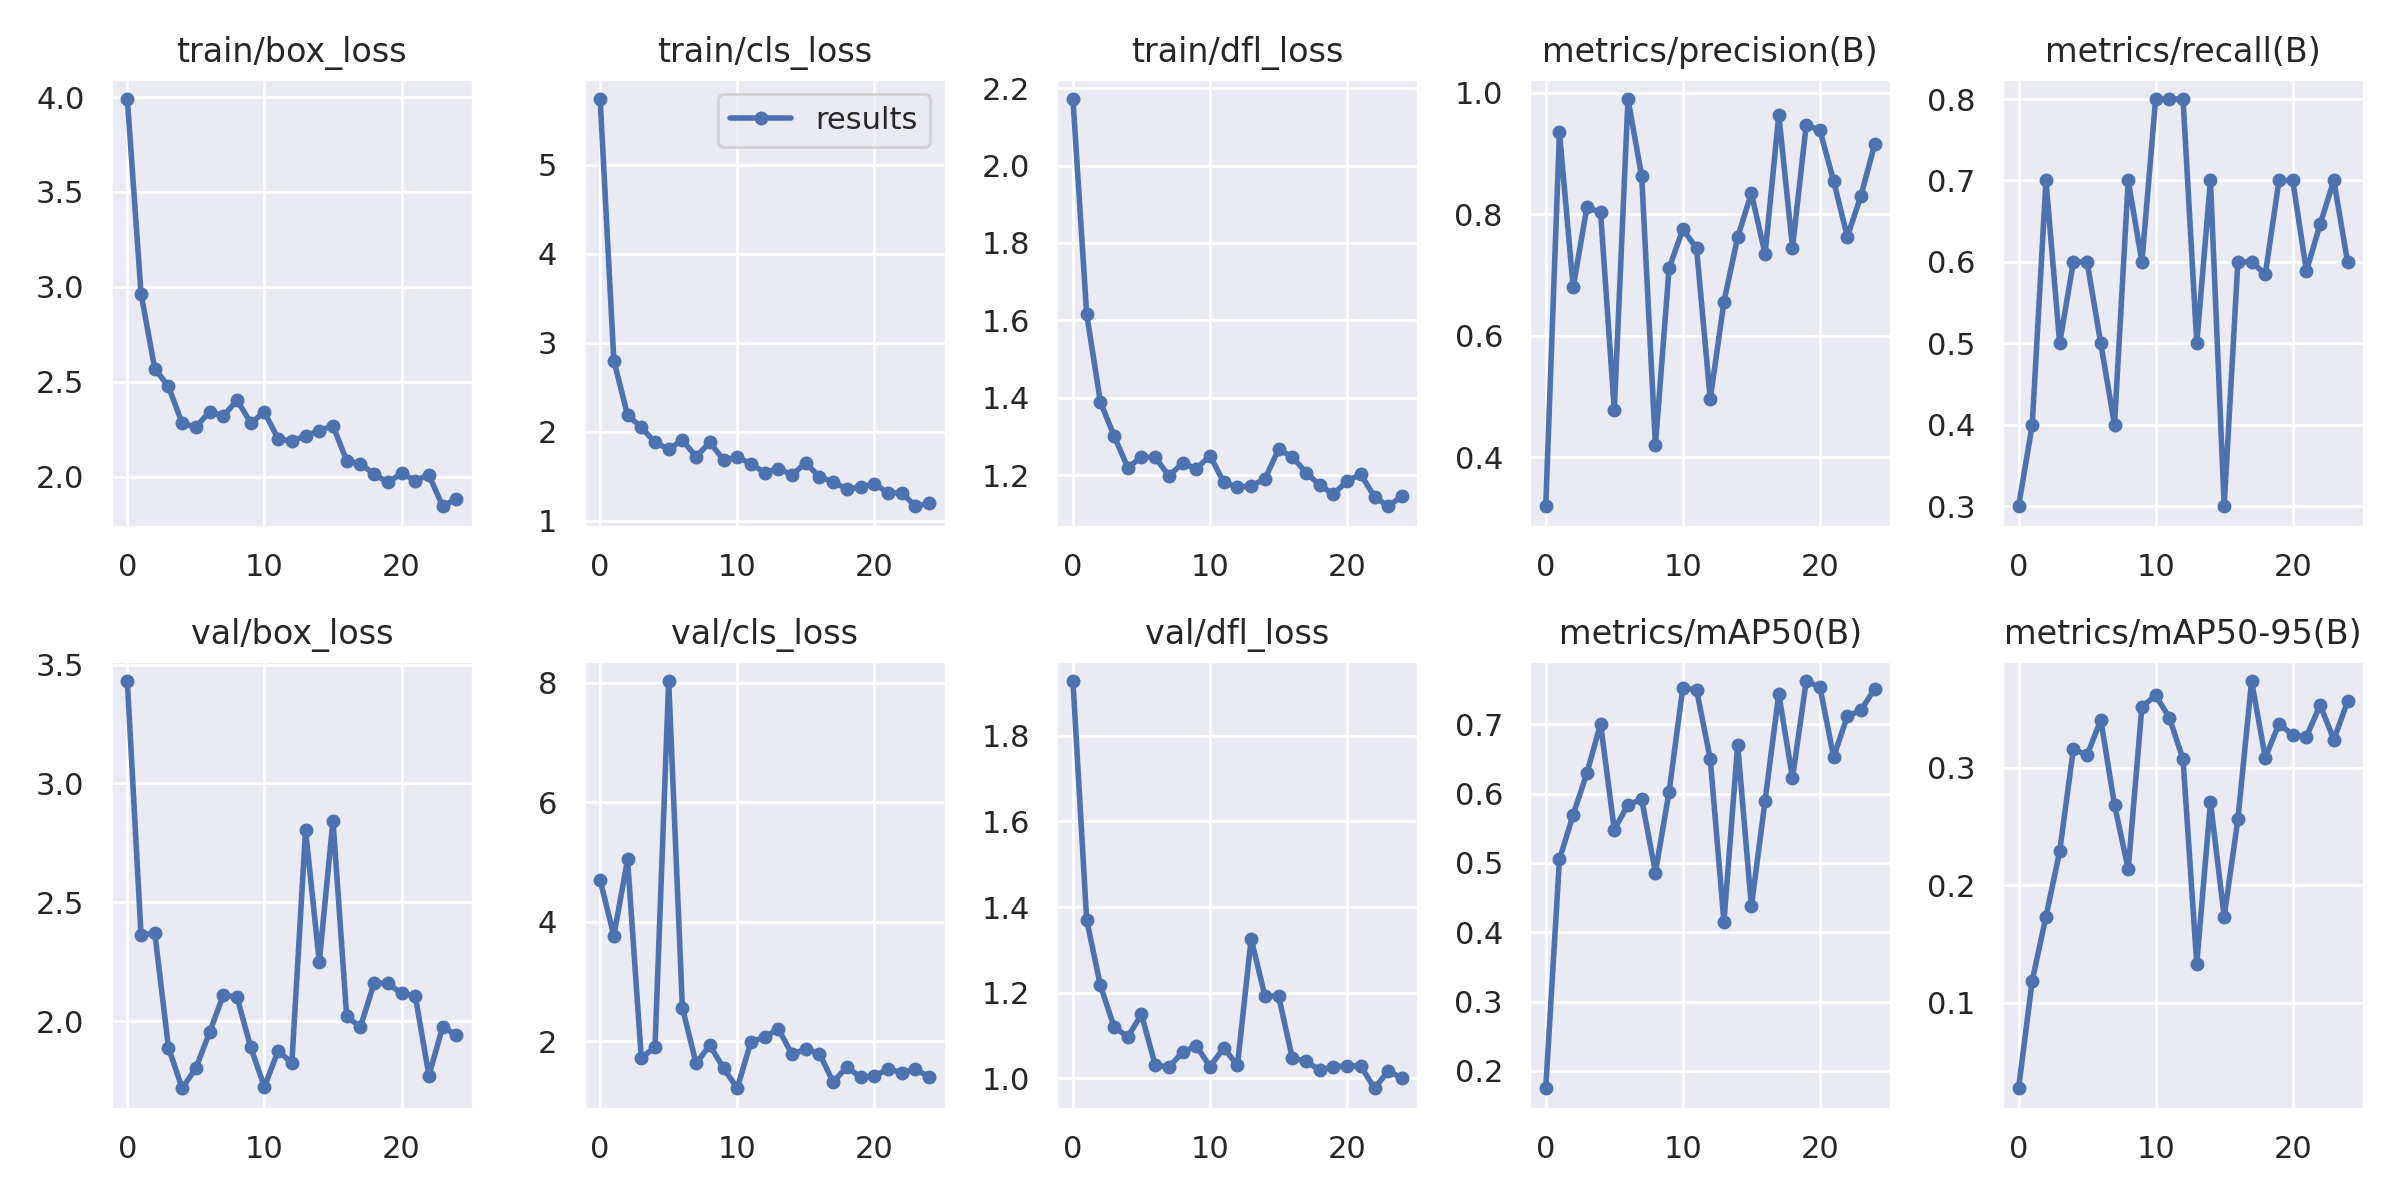

In [59]:
Image(filename='runs/detect/train3/results.png', width=600)

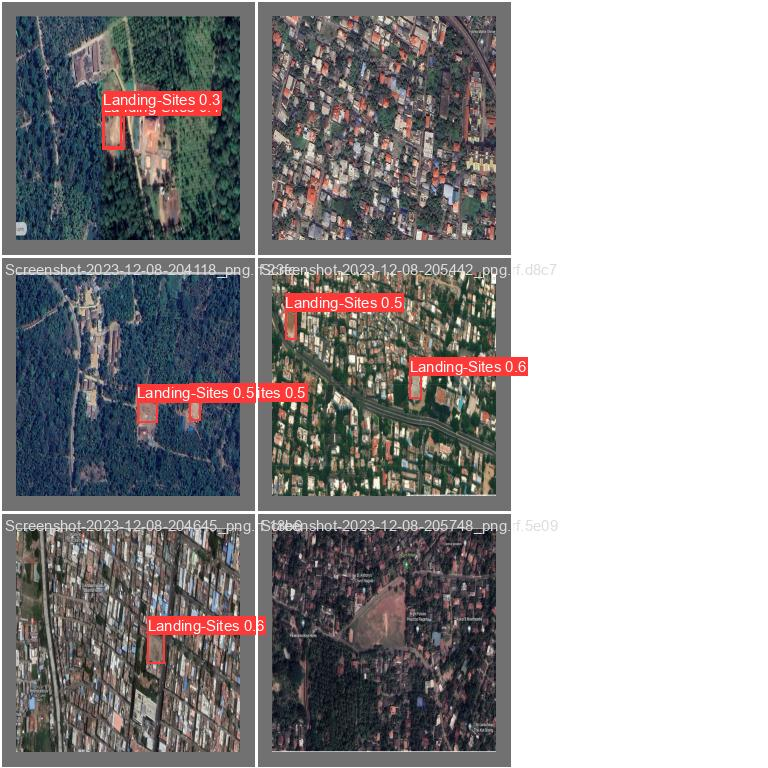

In [60]:
Image(filename='runs/detect/train3/val_batch0_pred.jpg', width=600)

In [61]:
!yolo task=detect mode=val model=runs/detect/train3/weights/best.pt data=data.yaml

2024-04-24 14:47:08.546111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 14:47:08.546165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 14:47:08.666145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 14:47:10.840738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, 

In [62]:
!yolo task=detect mode=predict model=runs/detect/train3/weights/best.pt conf=0.25 source= test/images save=True

2024-04-24 14:47:21.288488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 14:47:21.288540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 14:47:21.289974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 14:47:22.405495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/6 /content/drive/MyDriv

In [63]:
!yolo task=detect mode=predict model=runs/detect/train3/weights/best.pt conf=0.25 source=/content/image.png save=True


2024-04-24 14:47:35.058728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 14:47:35.058777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 14:47:35.060246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 14:47:36.160277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/image.png: 2

#Testing the YOLOv8 model

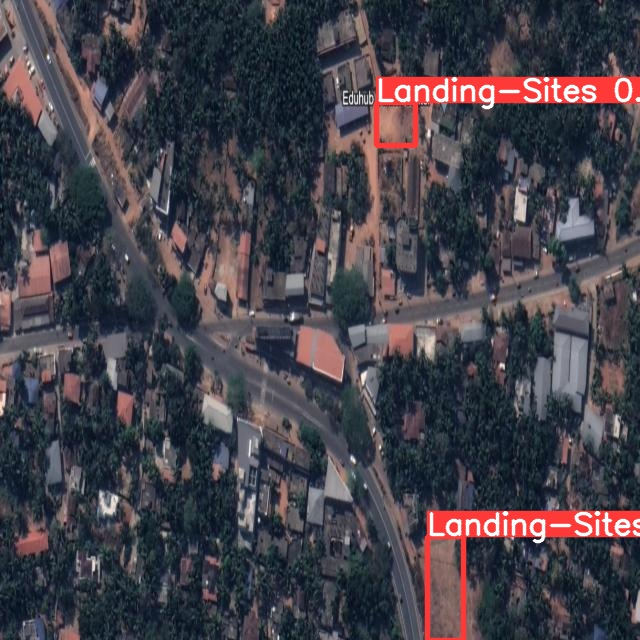

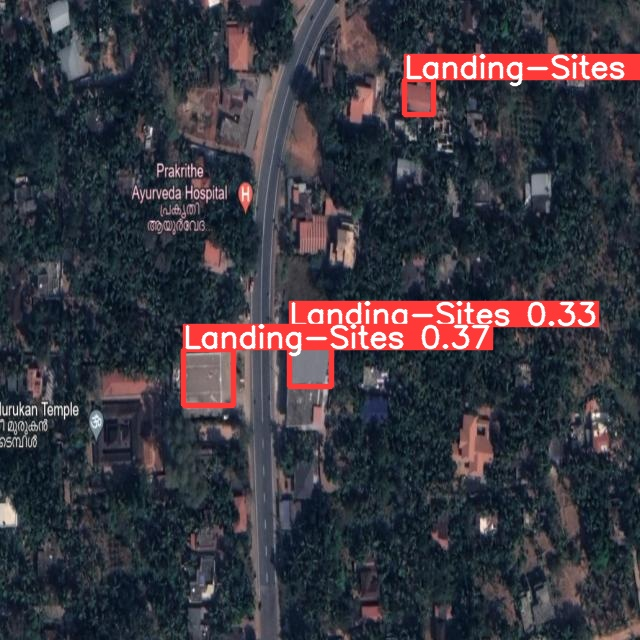

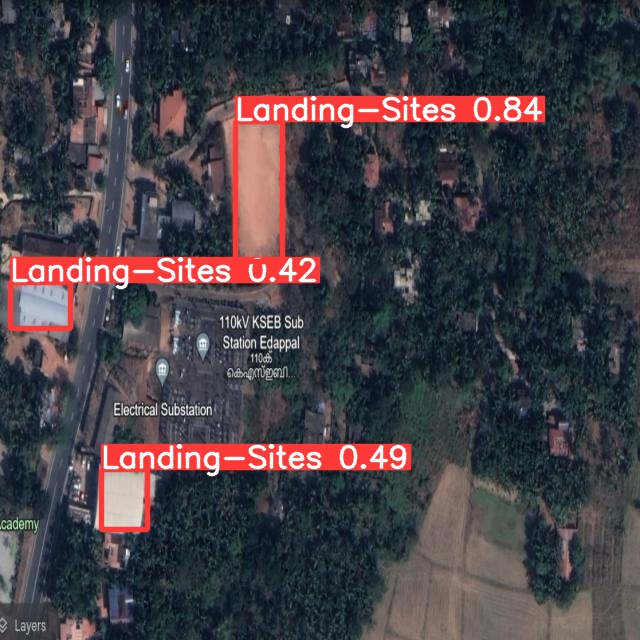

In [64]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

#Combining both the U-Net and YOLOv8 models


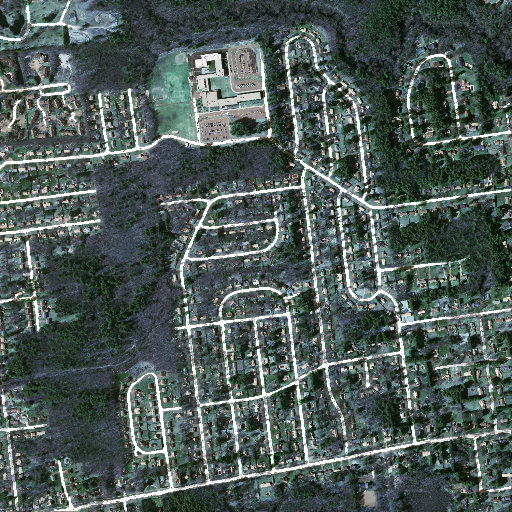

In [65]:
from IPython.display import Image, display
import glob

image_paths = glob.glob("/content/road_extracted.png")
if image_paths:  # Check if there are any images found
    display(Image(filename=image_paths[0], width=600))


In [71]:
!yolo task=detect mode=predict model=runs/detect/train3/weights/best.pt conf=0.25 source=/content/road_extracted.png save=True
 # You need to adjust this path based on where YOLO saves the output


2024-04-24 14:55:34.488530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 14:55:34.488595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 14:55:34.490748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 14:55:36.092146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
image 1/1 /content/road_extracted.png: 224x224 1 Landing-Sites, 7.0ms
Spe

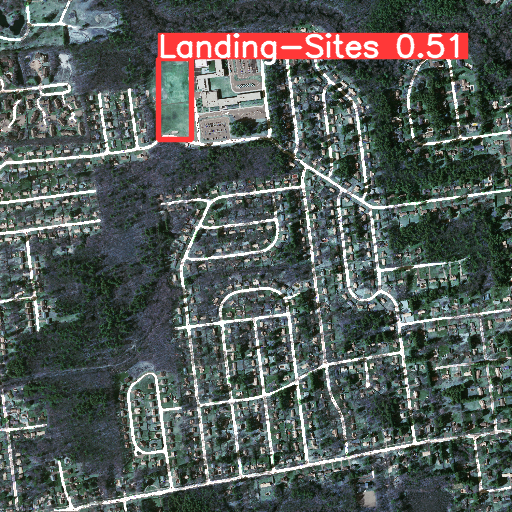

In [72]:
from IPython.display import Image, display
import glob

image_paths = glob.glob("runs/detect/predict8/road_extracted.png")
if image_paths:  # Check if there are any images found
    display(Image(filename=image_paths[0], width=600))
